<a href="https://colab.research.google.com/github/Davi-Esmeraldo/TCC/blob/main/TCC_Webscraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Sugestão 1: Um estudo comparativo de "redes neurais profundas" e "modelos de aprendizado de máquina" para classificação de textos do poder judiciario
# Sugestão 2: Um estudo comparativo de "redes neurais profundas" e "modelos de aprendizado de máquina" para Reconhecimento de Entidades Nomeadas de textos do poder judiciario

# Sugestão 3: Criação de chatbot com textos do poder judiciario

In [2]:
# 1. Webscraping

import requests  # Biblioteca para realizar requisições HTTP e acessar páginas da web
from bs4 import BeautifulSoup  # Ferramenta para extrair dados de HTML e XML de forma estruturada
import time  # Utilizado para criar pausas entre as requisições, evitando sobrecarga no servidor
import re  # Biblioteca para trabalhar com expressões regulares e buscar padrões de texto


In [4]:
# 1. Webscraping

# Função para extrair o conteúdo específico de uma portaria
def extrair_conteudo(link):
    try:
        response = requests.get(link)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            texto_completo = soup.get_text(separator='\n', strip=True)
            #padrao = (
            #    r"Poder Judiciário da União\s+Tribunal de Justiça do Distrito Federal e dos Territórios\s+Gabinete da Presidência\s+PORTARIA GPR"
            #    r"(.*?)ESTE TEXTO NÃO SUBSTITUI"
            #)
            padrao = (
                r"Poder Judiciário da União\s+"
                r"Tribunal de Justiça do Distrito Federal e dos Territórios\s+"
                r"Gabinete da Presidência\s+PORTARIA GPR\s+"
                r"\d+\s+DE\s+\d{1,2}\s+DE\s+[A-Z]+(?:\s+DE\s+\d{4})?\s+(.*?)ESTE TEXTO NÃO SUBSTITUI"
            )
            match = re.search(padrao, texto_completo, re.DOTALL | re.IGNORECASE)
            return match.group(1).strip() if match else "Conteúdo não encontrado."
        else:
            print(f"Erro ao acessar {link}: {response.status_code}")
            return "Erro ao acessar o conteúdo."
    except Exception as e:
        print(f"Erro ao acessar {link}: {e}")
        return "Erro ao acessar o conteúdo."

In [5]:
# 1. Webscraping

# Função para buscar e extrair links de uma página específica
def extrair_links(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        portarias = {}
        for link in soup.find_all('a'):
            href = link.get('href')
            texto = link.get_text(strip=True)
            if 'portaria' in texto.lower() or (href and 'pdf' in href.lower()):
                numero = re.findall(r'\d+', texto)
                if numero:
                    numero_portaria = numero[0]
                    link_completo = (
                        href if href.startswith('http')
                        else f"https://www.tjdft.jus.br{href}"
                    )
                    conteudo = extrair_conteudo(link_completo)

                    # Extração de data embutida
                    padrao_data = r'\d{2}/\d{2}/\d{4}'  # Padrão para datas no formato dd/mm/aaaa
                    match = re.search(padrao_data, texto)
                    data = match.group() if match else None

                    portarias[numero_portaria] = {
                        'data': data,
                        'conteudo': conteudo
                    }
        return portarias
    else:
        print(f"Erro ao acessar {url}: {response.status_code}")
        return {}


In [6]:
# 1. Webscraping

# Função principal para percorrer todas as páginas e extrair informações
def scraping_paginacao(base_url, paginas, delay=1):
    todas_portarias = {}
    for pagina in range(1, paginas + 1):
        url_pag = f"{base_url}?b_start:int={(pagina - 1) * 30}"
        print(f"Acessando: {url_pag}")
        portarias = extrair_links(url_pag)
        todas_portarias.update(portarias)
        time.sleep(delay)
    return todas_portarias


In [7]:
# 1. Webscraping

# URL base e número de páginas
base_url = "https://www.tjdft.jus.br/publicacoes/publicacoes-oficiais/portarias-gpr/2024"

# Realizar testes com a ultima pagina
numero_paginas_teste = 1

# quantidade_de_paginas =

# Executa o scraping e armazena todas as portarias
todas_portarias = scraping_paginacao(base_url, numero_paginas_teste, delay=0)

print(todas_portarias)


Acessando: https://www.tjdft.jus.br/publicacoes/publicacoes-oficiais/portarias-gpr/2024?b_start:int=0
{'1895': {'data': '28/11/2024', 'conteudo': 'O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E DOS TERRITÓRIOS, no uso de suas atribuições legais e regimentais, considerando a previsão contida no artigo 3º da\nPortaria Conjunta nº 2 de 10 de setembro de 2019\n, do Conselho Nacional de Justiça e do Conselho Nacional do Ministério Público, ad referendum do Conselho Especial, e tendo em vista o contido no processo SEI 0037365/2023,\nRESOLVE:\nArt. 1º Prorrogar o afastamento do Excelentíssimo Juiz de Direito Atalá Correia das funções jurisdicionais no Tribunal de Justiça do Distrito Federal e dos Territórios, por 1 (um) ano, a contar de 5 de dezembro de 2024, para que continue atuando como Juiz Assessor de Apoio Interinstitucional do Conselho Nacional do Ministério Público.\nArt. 2º Esta portaria entra em vigor na data de sua publicação, com efeitos a partir de 5 de dezembro de 202

In [ ]:
# Sugestão 1 - SIMILARITIES

# Proximidade e similaridade

# Modelos de Classificação ( Topic Clssification/ Identification)
# Dificuldade modelos supervisionados -  Classificação com Machine Learning (Ex.: SVM, Random Forest, Naive Bayes


In [ ]:
# Sugestão 1


# Word Embeddings :
# Descrição: Transformar palavras em vetores numéricos, capturando relações semânticas.
# Aplicação: Analisar similaridade entre portarias e descobrir quais documentos possuem conteúdo próximo ou complementar.

# Statistical Weighting of Words
# Methods Examples word2vec,doc2vec, Glove, fastText, TF-IDF and  transformer-based architectures

# Word vectors visualizations
# Extract two principal components using PCA.

# Agrupamento estocastico de vizinhanca com distribuicao t-student — t-distributed stochastic neighbor embedding (t-SNE). t-SNE

# Latent Dirichlet Allocation (LDA):
# Descrição: Modelo de tópicos que identifica temas presentes em um conjunto de textos.
# Aplicação: Descobrir temas principais em diversas portarias e associá-los automaticamente a cada documento.
# LDA visualization
# https://tlfvincent.github.io/2015/10/23/presidential-speech-topics/


# 3.5 Naive Bayes classification Model
# Import train_test_split
#from sklearn.model_selection import train_test_split
# Split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(,  test_size=0.25)
# Generate training Bow vectors
#X_train_bow = vectorizer.fit_transform(X_train)
# Generate test BoW vectors
#X_test_bow = vectorizer.transform(X_test)
# Import MultinomialNB
#from sklearn.naive_bayes import MultinomialNB
# Create MultinomialNB object
#clf = MultinomialNB()
# Train clf
#clf.fit(X_train_bow, y_train)
# Compute accuracy on test set
#accuracy = clf.score(X_test_bow, y_test)
#print(accuracy)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


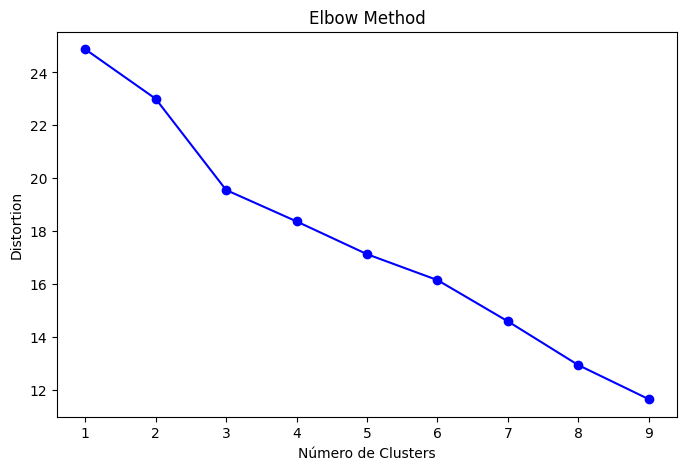


Cluster 0:
0     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
2     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
10    Altera a\nPortaria GPR 1947 de 10 de agosto de...
11    Altera a\nPortaria GPR 1900 de 03/08/2023\n, q...
16    Revoga a\nPortaria Conjunta 107 de 22 de agost...
Name: content, dtype: object

Cluster 1:
4     Estabelece a escala de plantão semanal da 2ª I...
5     Estabelece a escala de plantão judicial do Con...
13    Estabelece a escala de plantão semanal da 2ª I...
14    Estabelece a escala de plantão judicial do Con...
22    Estabelece a escala de plantão semanal da 2ª I...
23    Estabelece a escala de plantão judicial do Con...
Name: content, dtype: object

Cluster 2:
1     Indica membro para composição da Comissão de J...
3     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
6     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
7     Prorroga o afastamento do Juiz de Direito Subs...
8     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
9         

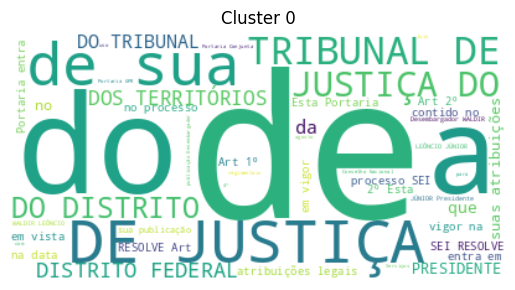

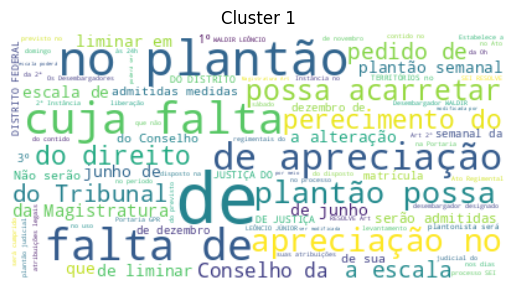

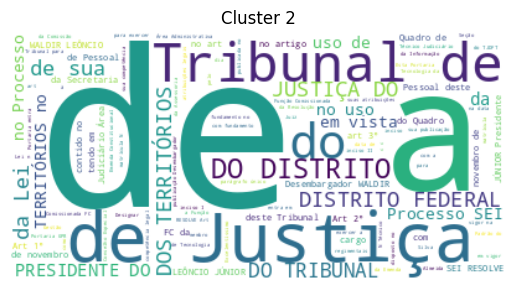

In [25]:
# 1.1 Clusterização
# Text Clustering (Cluster - Kmeans)

# TF-IDF
# (Term Frequency-Inverse Document Frequency)  ( Simple and basic method)
# TF-IDF function intended to reflect how important a word is to a document based on how recurring a word or token is
#  in a corpus by giving each word a score that ranges from 0 to 1.


import json # Manipulação de dados em formato JSON
import pandas as pd # Manipulação e análise de dados estruturados
from sklearn.feature_extraction.text import TfidfVectorizer # Word Embeddings usando TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.cluster import KMeans # Aprendizado não supervisionado Cluterização KMeans
import matplotlib.pyplot as plt # Gráficos e visualizações
from wordcloud import WordCloud # Nuvens de palavras
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words_portuguese = stopwords.words('portuguese')


# Converter o dicionário para um DataFrame
df = pd.DataFrame.from_dict(todas_portarias, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'id', 'data': 'date', 'conteudo': 'content'}, inplace=True)

# Vetorização dos textos com TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_portuguese, max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])

# Determinar o número de clusters usando o método do cotovelo
distortions = []
K = range(1, 10)
for k in K:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(X_tfidf)
    distortions.append(kmeans_model.inertia_)

# Visualizar o método do cotovelo
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

#  Número de clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_tfidf)
df['cluster'] = kmeans.labels_

# Exibir os textos agrupados
for cluster in range(num_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster]['content'])

# Criar nuvens de palavras para cada cluster
for cluster in range(num_clusters):
    cluster_texts = " ".join(df[df['cluster'] == cluster]['content'])
    wordcloud = WordCloud(stopwords='portuguese', background_color='white').generate(cluster_texts)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


# Revisão stop words específicas



Cluster 0:
3     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
6     O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
12    O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
15    O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
Name: content, dtype: object

Cluster 1:
4     Estabelece a escala de plantão semanal da 2ª I...
5     Estabelece a escala de plantão judicial do Con...
13    Estabelece a escala de plantão semanal da 2ª I...
14    Estabelece a escala de plantão judicial do Con...
22    Estabelece a escala de plantão semanal da 2ª I...
23    Estabelece a escala de plantão judicial do Con...
Name: content, dtype: object

Cluster 2:
7     Prorroga o afastamento do Juiz de Direito Subs...
24    Autoriza o afastamento do Juiz de Direito Subs...
Name: content, dtype: object

Cluster 3:
21    O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
27    O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRIT...
Name: content, dtype: object

Cluster 4:
28    O PRESIDENTE DO TRIBUNAL DE JUSTIÇ

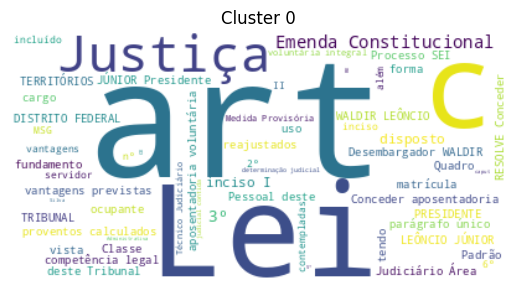

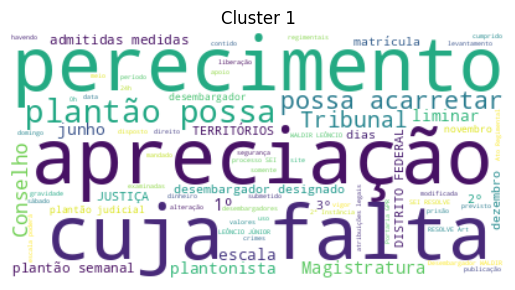

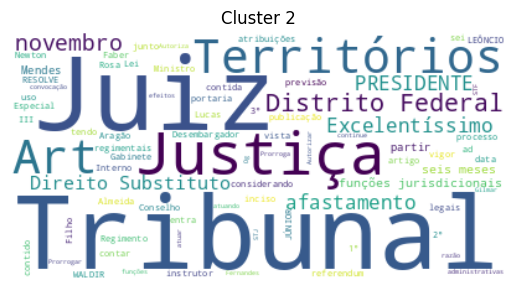

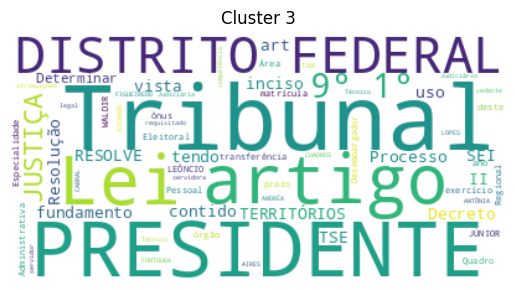

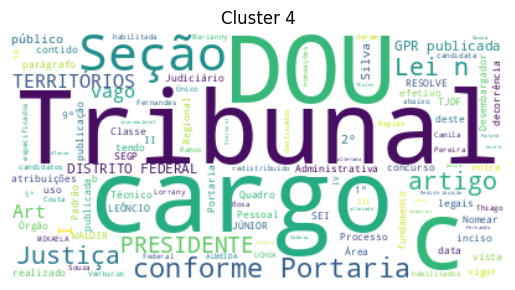

In [21]:
# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity


# Converter o dicionário para um DataFrame
df = pd.DataFrame.from_dict(todas_portarias, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'id', 'data': 'date', 'conteudo': 'content'}, inplace=True)

# Vetorização dos textos com TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_portuguese, max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])

# Aplicando DBSCAN diretamente com métrica 'cosine'
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(X_tfidf)

# Adiciona os clusters ao DataFrame
df['cluster'] = clusters

# Exibir os textos agrupados
unique_clusters = set(clusters)
for cluster in unique_clusters:
    if cluster == -1:
        print("\nCluster -1 (Ruído):")
    else:
        print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster]['content'])

# Criar nuvens de palavras para cada cluster válido
for cluster in unique_clusters:
    if cluster == -1:
        continue  # Ignorar ruídos
    cluster_texts = " ".join(df[df['cluster'] == cluster]['content'])
    wordcloud = WordCloud(stopwords=set(stop_words_portuguese), background_color='white').generate(cluster_texts)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


In [24]:
# Métricas para Comparação de Agrupamentos

# Silhouette Score
# Mede a coesão (quão próximos os pontos de um mesmo cluster estão) e a separação (quão distantes estão os clusters entre si). # Valores próximos de 1 indicam clusters bem definidos, enquanto valores próximos de -1 indicam má separação.

from sklearn.metrics import silhouette_score

# Para K-Means
silhouette_kmeans = silhouette_score(X_tfidf, kmeans.labels_)
print(f"Silhouette Score (K-Means): {silhouette_kmeans}")

# Para DBSCAN
silhouette_dbscan = silhouette_score(X_tfidf, dbscan.labels_)
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")

# Davies-Bouldin Index
# Mede a média das razões entre a distância intra-cluster e a distância inter-cluster # Valores mais baixos indicam melhores agrupamentos.

from sklearn.metrics import davies_bouldin_score

# Para K-Means
db_index_kmeans = davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
print(f"Davies-Bouldin Index (K-Means): {db_index_kmeans}")

# Para DBSCAN
db_index_dbscan = davies_bouldin_score(X_tfidf.toarray(), dbscan.labels_)
print(f"Davies-Bouldin Index (DBSCAN): {db_index_dbscan}")

# Calinski-Harabasz Index
#Mede a razão entre a dispersão total intra-cluster e inter-cluster. Valores mais altos indicam clusters mais definidos.

from sklearn.metrics import calinski_harabasz_score

# Para K-Means
ch_index_kmeans = calinski_harabasz_score(X_tfidf.toarray(), kmeans.labels_)
print(f"Calinski-Harabasz Index (K-Means): {ch_index_kmeans}")

# Para DBSCAN
ch_index_dbscan = calinski_harabasz_score(X_tfidf.toarray(), dbscan.labels_)
print(f"Calinski-Harabasz Index (DBSCAN): {ch_index_dbscan}")


# O DBSCAN apresentou melhor desempenho geral, considerando o Silhouette Score e o índice de Davies-Bouldin. Isso indica que ele capturou agrupamentos mais naturais, possivelmente identificando estruturas de densidade e ignorando ruídos nos dados.
# O K-Means teve uma leve vantagem no índice de Calinski-Harabasz, mas os outros indicadores sugerem que ele não lidou tão bem com os dados.



# 1. Mean Shift
# 2. Agglomerative Clustering (Hierarchical Clustering)
# 3. Spectral Clustering
# 4. OPTICS (Ordering Points To Identify Clustering Structure)
# 5. Gaussian Mixture Model (GMM)



Silhouette Score (K-Means): 0.1405210180123868
Silhouette Score (DBSCAN): 0.22037862168543146
Davies-Bouldin Index (K-Means): 2.4918232429253586
Davies-Bouldin Index (DBSCAN): 1.5451406147549305
Calinski-Harabasz Index (K-Means): 3.6766791343228835
Calinski-Harabasz Index (DBSCAN): 3.404899592334142


In [10]:
# Sugestão 2

# Reconhecimento de Entidades Nomeadas (REN) -  Named Entity Recognition (NER)

# Nlp_sm

import nltk  # Biblioteca para processamento de linguagem natural (NLP)
import spacy  # Biblioteca avançada para NLP com suporte robusto a várias línguas
from nltk.tokenize import sent_tokenize, word_tokenize  #  Funções para tokenização no NLTK
from nltk.corpus import stopwords  # Módulo para acessar listas de stopwords em várias línguas.
from nltk.stem import RSLPStemmer  # Algoritmo de stemming para português.
import string # Módulo padrão do Python para manipulação de caracteres

# Baixando os recursos necessários do NLTK
nltk.download('punkt')
#nltk.download('stopwords')
nltk.download('rslp')

!pip install spacy
!python -m spacy download pt_core_news_sm

# modelo de idioma pequeno
nlp_sm = spacy.load("pt_core_news_sm")

!pip install spacy
!python -m spacy download pt_core_news_lg

# modelo de idioma grande
nlp_lg = spacy.load("pt_core_news_lg")

def processar_portarias(portarias):
    resultados = {}

    for numero, detalhes in portarias.items():
        conteudo = detalhes['conteudo']
        doc = nlp_sm(conteudo)
        entidades = [(ent.text, ent.label_) for ent in doc.ents]

        resultados[numero] = {
            'data': detalhes['data'],
            'conteudo': conteudo,
            'entidades': entidades
        }

    return resultados

# Processar as portarias
resultados_ner = processar_portarias(todas_portarias)

# Exibir os resultados
for numero, info in resultados_ner.items():
    print(f"Portaria {numero} - Data: {info['data']}")
    print(f"Conteúdo: {info['conteudo']}")
    print("Entidades reconhecidas:")
    for entidade, tipo in info['entidades']:
        print(f"  - {entidade} ({tipo})")
    print()


Portaria 1895 - Data: 28/11/2024
Conteúdo: O PRESIDENTE DO TRIBUNAL DE JUSTIÇA DO DISTRITO FEDERAL E DOS TERRITÓRIOS, no uso de suas atribuições legais e regimentais, considerando a previsão contida no artigo 3º da
Portaria Conjunta nº 2 de 10 de setembro de 2019
, do Conselho Nacional de Justiça e do Conselho Nacional do Ministério Público, ad referendum do Conselho Especial, e tendo em vista o contido no processo SEI 0037365/2023,
RESOLVE:
Art. 1º Prorrogar o afastamento do Excelentíssimo Juiz de Direito Atalá Correia das funções jurisdicionais no Tribunal de Justiça do Distrito Federal e dos Territórios, por 1 (um) ano, a contar de 5 de dezembro de 2024, para que continue atuando como Juiz Assessor de Apoio Interinstitucional do Conselho Nacional do Ministério Público.
Art. 2º Esta portaria entra em vigor na data de sua publicação, com efeitos a partir de 5 de dezembro de 2024.
Desembargador WALDIR LEÔNCIO JÚNIOR
Presidente
Entidades reconhecidas:
  - TRIBUNAL DE JUSTIÇA (ORG)
  - D

In [ ]:
# LeNER-Br

#import os

# Caminho para o arquivo train.txt
#caminho_train = r"C:\Users\daviz\Downloads\NLP-TCC\lener-br-master\model\data\train.txt"

# Função para carregar o arquivo e separar tokens e etiquetas
#def carregar_dados_bio(caminho_arquivo):
#    textos = []  # Lista de sentenças (cada sentença é uma lista de tokens)
#    etiquetas = []  # Lista de etiquetas para cada sentença
#    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
#        sentenca_tokens = []
#        sentenca_etiquetas = []
#        for linha in f:
#            linha = linha.strip()
#            if linha == "":  # Linha vazia indica o final de uma sentença
#                if sentenca_tokens:
#                    textos.append(sentenca_tokens)
#                    etiquetas.append(sentenca_etiquetas)
#                    sentenca_tokens = []
#                    sentenca_etiquetas = []
#            else:
                # Separar token e etiqueta
#                partes = linha.split()  # Divide o token da etiqueta
#                token = partes[0]
#                etiqueta = partes[1] if len(partes) > 1 else "O"
#                sentenca_tokens.append(token)
#                sentenca_etiquetas.append(etiqueta)
#        # Adicionar a última sentença, se necessário
#        if sentenca_tokens:
#            textos.append(sentenca_tokens)
#            etiquetas.append(sentenca_etiquetas)
#    return textos, etiquetas

# Carregar os dados
#textos, etiquetas = carregar_dados_bio(caminho_train)

# Exemplo de visualização
#print(f"Número de sentenças carregadas: {len(textos)}")
#print(f"Primeira sentença: {textos[0]}")
#print(f"Etiquetas da primeira sentença: {etiquetas[0]}")


In [ ]:
# Sugestão 3 -  Chat Bots

#from flask import Flask, request, jsonify

#ids = list(todas_portarias.keys())
#textos = [doc['conteudo'] for doc in todas_portarias.values()]

# Vetorização com TF-IDF

#vectorizer = TfidfVectorizer(stop_words=stop_words_portuguese)
#X_tfidf = vectorizer.fit_transform(textos)

# Configuração do chatbot
#app = Flask(__name__)

#@app.route("/chatbot", methods=["POST"])
#def chatbot():
#    user_query = request.json.get("query", "").lower()
#
#    # Vetorização da consulta
#    query_vec = vectorizer.transform([user_query])

#    # Similaridade com os documentos
#    similarities = cosine_similarity(query_vec, X_tfidf).flatten()

#    # Encontrar o documento mais relevante
#    top_idx = np.argmax(similarities)
#    top_similarity = similarities[top_idx]
#
#    if top_similarity > 0.2:  # Um limiar para relevância
#        response = {
#            "id": ids[top_idx],
#            "data": todas_portarias[ids[top_idx]]["data"],
#            "conteudo": todas_portarias[ids[top_idx]]["conteudo"],
#        }
#    else:
#        response = {"message": "Desculpe, não encontrei resultados relevantes."}
#
#    return jsonify(response)
#
#if __name__ == "__main__":
#    app.run(debug=True)



*Outras* Possíveis Aplicações:

In [ ]:
# Modelagem com Séries Temporais (ARIMA, Prophet):
# Aplicação: Prever a ocorrência de temas ou tipos de portarias futuras com base em padrões temporais anteriores.

In [ ]:
# 3. Data Visualization
# Gráfico 3: Distribuição de Etiquetas POS
# contagem_pos = Counter(pos_tags)

# plt.figure(figsize=(8, 4))
# sns.barplot(x=list(contagem_pos.keys()), y=list(contagem_pos.values()), palette="muted")
# plt.title("Distribuição de Etiquetas Gramaticais (POS)")
# plt.xlabel("Etiquetas POS")
# plt.ylabel("Frequência")
# plt.show()

# OBS: Traduzir para o portugues

# Distribuição de palavras e bigramas/trigramas: Avaliar a frequência de palavras e pares (bigramas) ou trios (trigramas) de palavras para entender padrões no texto.